# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import datetime










# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

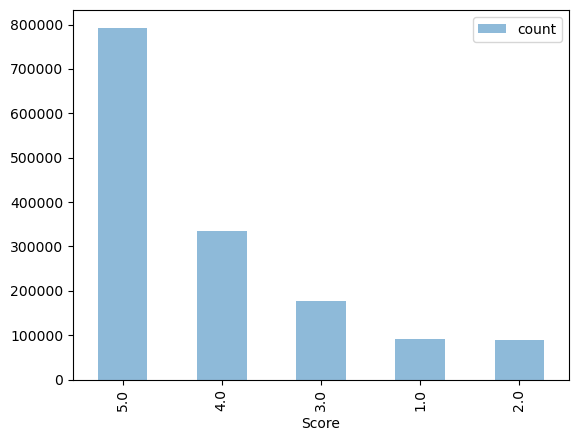


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")
#take this out in later testing
# trainingSet = trainingSet.sample(frac=0.1, random_state=42)
# testingSet= testingSet.sample(frac=0.1, random_state=42) 
# trainingSet = trainingSet.dropna()
# trainingSet = trainingSet.drop(columns=['ProductId','UserId'])

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()


print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def calculate_sentiment(text):
    """Calculate sentiment polarity and subjectivity for the given text."""
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity
def add_sentiment_features(df):
    """Add sentiment features to the DataFrame."""
    
    # Ensure that all entries in the 'Summary' column are strings
    df['Summary'] = df['Summary'].astype(str)
    
    # Apply the sentiment analysis function and handle possible exceptions
    df['SentimentPolarity'], df['SentimentSubjectivity'] = zip(
        *df['Summary'].apply(calculate_sentiment)
    )
    
    return df

def add_features_to(df, count_vectorizer=None,lda_model=None, num_topics=5):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    #changes this from summary to text
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(str(x)))
    df['SummaryWordCount'] = df['Summary'].apply(lambda x: len(str(x).split()))
    current_time = datetime.datetime.now().timestamp()
    print("current time:",current_time)
    df['ReviewAge'] = current_time - df['Time']


    # If vectorizer is provided, use it to transform 'Summary'
    df = add_sentiment_features(df)
    if count_vectorizer:
        count_matrix = count_vectorizer.transform(df['Summary'].fillna(''))
        count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
        df = pd.concat([df.reset_index(drop=True), count_df.reset_index(drop=True)], axis=1)

        # If LDA model is provided, transform the count matrix to get topic distributions
        if lda_model:
            lda_features = lda_model.transform(count_matrix)
            lda_df = pd.DataFrame(lda_features, columns=[f'Topic_{i}' for i in range(num_topics)])
            df = pd.concat([df.reset_index(drop=True), lda_df.reset_index(drop=True)], axis=1)



    return df
    


if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    # X_train = pd.read_csv("./data/X_train.csv")
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
    

else:
    print("in else statement")
    # Initialize the TF-IDF vectorizer
    count_vectorizer = CountVectorizer(max_features=100)
    print("j vectorized")

    # Fit the vectorizer on the training set's 'Summary' column
    count_vectorizer.fit(trainingSet['Summary'].fillna(''))
    count_matrix = count_vectorizer.transform(trainingSet['Summary'].fillna(''))

    print("j fit the vectorized data")
    
    
    # Initialize LDA
    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust num_topics as needed
    lda_model.fit(count_matrix)


    # Process the DataFrame with the vectorizer
    train = add_features_to(trainingSet, count_vectorizer=count_vectorizer,lda_model=lda_model)
    print("added features for train")

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    print("finished merging that took forever")
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    # Save the processed data and the vectorizer
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)
    with open('./data/count_vectorizer.pkl', 'wb') as f:
        pickle.dump(count_vectorizer, f)
    with open('./data/lda_model.pkl', 'wb') as f:
        pickle.dump(lda_model, f)

in else statement
j vectorized
j fit the vectorized data
current time: 1730136006.399779
added features for train
finished merging that took forever


# Sample + Split into training and testing set

In [4]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)


# Feature Selection

In [5]:
#removed time
# numeric_columns = X_train.select_dtypes(include=['number']).columns
# categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
# X_train_numeric = X_train[numeric_columns]
# X_test_numeric = X_test[numeric_columns]
# X_submission_numeric = X_submission[numeric_columns]
# preprocessor_before_smote = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_columns),
        
#     ],
# )

# Transform X_train using the preprocessor
# X_train_preprocessed = preprocessor_before_smote.fit_transform(X_train_numeric)
# X_test_preprocessed = preprocessor_before_smote.transform(X_test_numeric)

# #DEBUG - SMoting X_Submission ****
# # Apply SMOTE to balance the training set
# # preprocessed_column_names = preprocessor_before_smote.get_feature_names_out()
# X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=numeric_columns)
# X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=numeric_columns)

# smote = SMOTE(random_state=42)
# X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_preprocessed, Y_train)
# #DEBUG
# # X_test_balanced, Y_test_balanced = smote.fit_resample(X_test_preprocessed, Y_test)

# X_train_balanced = pd.DataFrame(X_train_balanced, columns=numeric_columns)
# X_test_balanced = pd.DataFrame(X_test_balanced, columns=numeric_columns)

# Now, continue with the feature selection and the rest of your pipeline
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 
            'SummaryLength', 'SummaryWordCount', 'SentimentPolarity', 
            'SentimentSubjectivity', 'ReviewAge'] + count_vectorizer.get_feature_names_out().tolist()

# updated_features = [feature for feature in original_features]

# # Now you can filter features to select only those present in X_train_balanced
# features = [feature for feature in updated_features if feature in X_train_balanced.columns]
# scaler = StandardScaler()
def get_best(X,Y,features):
    k=40
    select_kbest_test = SelectKBest(score_func=f_classif, k=k)
    transform = select_kbest_test.fit_transform(X[features], Y)
    selected_features = [feature for feature, is_selected in zip(features, select_kbest_test.get_support()) if is_selected]
    print("Selected Features:", selected_features)
    transform = pd.DataFrame(transform, columns=selected_features)
    return transform, selected_features

# # Step 3: Fit and transform the training data
# X_train_yaya = scaler.fit_transform(X_train_balanced[features])
# print(features)
# X_train_yaya = pd.DataFrame(X_train_yaya, columns=features)

X_train_select,selected_features = get_best(X_train,Y_train,features)
# X_test_select,test_features = get_best(X_test_preprocessed,Y_test,features)
# Select relevant features - fave debug ***
X_test_select = X_test[selected_features]
X_submission_select = X_submission[selected_features]


# Standardize the numeric columns
#try standardizing with new columns 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ],
    remainder='passthrough'  # This keeps other columns (like the encoded categorical features) unchanged
)
# scaler = StandardScaler()
# X_test_yaya = scaler.fit_transform(X_test_select[test_features])
# X_test_select = pd.DataFrame(X_test_yaya,columns=test_features)

# # Apply the preprocessor to the training, test, and submission sets
# X_train_select_scaled = preprocessor.fit_transform(X_train_select)
# X_test_select_scaled = preprocessor.transform(X_test_select)
# X_submission_select_scaled = preprocessor.transform(X_submission_select)

# # Convert the transformed arrays back into DataFrames with the same column names for consistency
# X_train_select = pd.DataFrame(X_train_select_scaled, columns=features)
# X_test_select = pd.DataFrame(X_test_select_scaled, columns=features)
# X_submission_select = pd.DataFrame(X_submission_select_scaled, columns=features)








Selected Features: ['HelpfulnessDenominator', 'Helpfulness', 'SummaryLength', 'SummaryWordCount', 'SentimentPolarity', 'SentimentSubjectivity', 'ReviewAge', 'as', 'awesome', 'bad', 'best', 'better', 'but', 'classic', 'don', 'entertaining', 'ever', 'excellent', 'favorite', 'fun', 'good', 'great', 'interesting', 'love', 'loved', 'much', 'must', 'no', 'not', 'one', 'season', 'series', 'show', 'so', 'some', 'this', 'too', 'was', 'what', 'wonderful']


# Model Creation

In [8]:
X_train_select_scaled = preprocessor.fit_transform(X_train_select)
X_test_select_scaled = preprocessor.transform(X_test_select)
X_submission_select_scaled = preprocessor.transform(X_submission_select)
X_train_select = pd.DataFrame(X_train_select_scaled, columns=selected_features)
X_train_select.fillna(0, inplace=True) 
X_test_select = pd.DataFrame(X_test_select_scaled, columns=selected_features)
X_test_select.fillna(0, inplace=True) 
X_submission_select = pd.DataFrame(X_submission_select_scaled, columns=selected_features)
X_submission_select.fillna(0, inplace=True) 
# k=40
# k=50


model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        # ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', KNeighborsClassifier(n_neighbors=90))
])
# param_grid = {
#     'classifier__n_neighbors': [80,90,100], #best is 2
#     'classifier__weights': ['distance'], #uniform or distance
#     'classifier__p': [2]  # For KNN, 'p' parameter (1 = Manhattan distance, 2 = Euclidean) - change this to just 2 
# }
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     n_jobs=-1,
#     verbose=2,
#     refit=True
# )

# grid_search.fit(X_train_select, Y_train) #_balanced 
# # pipeline.fit(X_train_select, Y_train)
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)
# final_model = grid_search.best_estimator_  # Get the best model from grid search


# select_kbest = final_model.named_steps['feature_selection']
# selected_features_mask = select_kbest.get_support()
# selected_features = [feature for feature, is_selected in zip(features, selected_features_mask) if is_selected]
# select_kbest = SelectKBest(score_func=f_classif, k=k)

# X_test_selected = select_kbest.transform(X_test_select)
# X_train_selected = select_kbest.transform(X_train_select)

# selected_features = [feature for feature, is_selected in zip(features, select_kbest.get_support()) if is_selected]
# print("Selected Features:", selected_features)
# X_train_selected = pd.DataFrame(X_train_select, columns=selected_features)
# print(X_train_selected.head())

# X_train_selected = select_kbest.fit_transform(X_train_select, Y_train_balanced)
# X_train_selected = pd.DataFrame(X_train_select, columns=selected_features)

# X_train_selected=X_train_select[selected_features]

# cv_scores = cross_val_score(final_model, X_train_select, Y_train, cv=2)

cv_scores = cross_val_score(model, X_train_select, Y_train, cv=2)
print("finished cross validating")
model.fit(X_train_select, Y_train)
# X_test_selected = X_test_select[selected_features].values
# X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

Y_test_predictions = model.predict(X_test_select)

# Print the selected features to verify


# Step 4: Transform X_train_select and X_test_select using the fitted SelectKBest
# select_kbest_test = SelectKBest(score_func=f_classif, k=k)
# # X_test_selected = select_kbest.transform(X_test_select)
# X_test_selected = select_kbest.transform(X_test_select)
# selected_features = [feature for feature, is_selected in zip(features, select_kbest.get_support()) if is_selected]


# Note: Now X_train_selected and X_test_selected contain only the selected features.
# These are the versions you should use for training and testing.

# Step 5: Predict using the transformed test set


# Make predictions
# Predict the score using the model
# Y_test_predictions = final_model.predict(X_test_selected)

# select_kbest = final_model.named_steps['feature_selection']
# selected_features_mask = select_kbest.get_support()
# selected_features = [feature for feature, is_selected in zip(features, selected_features_mask) if is_selected]
# print("Selected Features:", selected_features)


finished cross validating


# Model Evaluation

Accuracy on testing set =  0.578750780963871


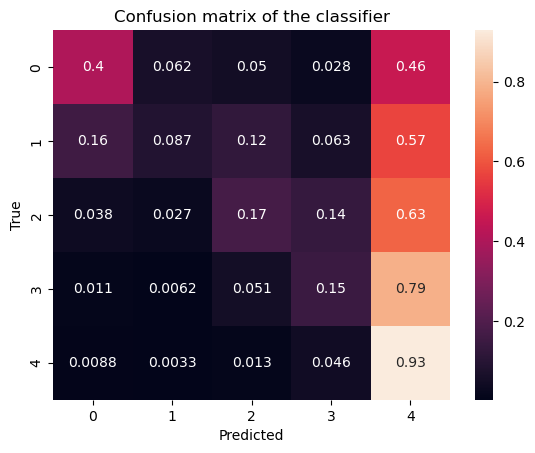

In [9]:
# Evaluate your model on the testing set
Y_test.reset_index(drop=True, inplace=True)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [10]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)